| ID | Description | Duration (min) | Dependencies | Status | Type |
|----|--------------|----------------|---------------|---------|--------|
| 0  | Get ready for the day (wake up, get dressed, make breakfast, go to café) | 60  | None | not_yet_started | Flexible |
| 1  | PCW | 120 | 0 | not_yet_started | Flexible |
| 2  | NS144 Class | 90 | 1 | not_yet_started | Fixed |
| 3  | Lunch | 90 | 2 | not_yet_started | Flexible |
| 4  | Work | 60 | 3 | not_yet_started | Flexible |
| 5  | Commute to Lab | 60 | 4 | not_yet_started | Flexible |
| 6  | Lab Meeting | 120 | 5 | not_yet_started | Fixed |
| 7  | Groceries (+ commute back) | 60 | 6 | not_yet_started | Flexible |
| 8  | Dinner (Steak because we are in Argentina) | 60 | 7 | not_yet_started | Flexible |
| 9  | PCW CS 110 | 120 | 8 | not_yet_started | Flexible |
| 10  | Get ready for sleep | 60 | 9 | not_yet_started | Flexible |


In [110]:

# 1. Task class

class Task:
    
    """
    Represents a single task in the scheduler.
    
    Attributes:
        id (int): Unique identifier for the task
        description (str): Short description of the task
        duration (int): Duration of the task in minutes
        dependencies (list[int]): List of task IDs that must be completed first, before task can be completed
        status (str): Current status ('not_yet_started', 'in_progress', 'completed')
        type (str): 'Fixed' or 'Flexible'
        priority (float): Automatically computed priority value

    creating this class will be useful to build on the input data later — it lets me easily compute task properties, 
    manage dependencies, and update attributes like status or priority as the scheduler runs.
    """
    
    def __init__(self, id, description, duration, dependencies=None, status='not_yet_started', type='Flexible'):
        self.id = id
        self.description = description
        self.duration = duration
        # handles both cases (tasks with/without dependencies) 
        if dependencies:
            self.dependencies = [int(d) for d in str(dependencies).replace(" ", "").split(",")]
        else:
            self.dependencies = []

        self.status = status
        self.type = type
        self.priority = 0.0  # will be computed later based on task type, duration, and dependencies

    def __repr__(self):
        return (Task({self.id}, {self.description}, priority={self.priority:.1}))


# 2. Create MaxHeap class to compute priority queue

class MaxHeap:
    """
    Implementation of a MaxHeap (priority queue).
    The highest-priority element is always at index 0.
    
    Methods:
        left(i), right(i), parent(i): return child or parent index positions
        heappush(task): insert a new task and restore heap order
        heappop(): remove and return the highest-priority task
        heapify(i): restore heap property starting from index i	
     
    This class will be used in the scheduler algorith to select the next task 
    with the highest priority. The heap helps maintain the heap property 
    (parents>children) after every insertion or removal, giving the O(log n) 
    performance for heappush and heappop operations.
    """
    
    def __init__(self):
        self.heap = []

    def left(self, i): return 2 * i + 1
    def right(self, i): return 2 * i + 2
    def parent(self, i): return (i - 1) // 2

    def heappush(self, task):
        """add a new task and move it up until the heap property is restored."""
        self.heap.append(task)
        index = len(self.heap) - 1
        # while parent has smaller priority, swap upward
        while index > 0:
            parent = self.parent(index)
            if self.heap[parent].priority >= self.heap[index].priority:
                break
            self.heap[parent], self.heap[index] = self.heap[index], self.heap[parent]
            index = parent

    def heapify(self, i):
        """Keep the largest priority task on top (restores heap order)."""
        size = len(self.heap)
        left = self.left(i)
        right = self.right(i)
        largest = i

        # check left child
        if left < size and self.heap[left].priority > self.heap[largest].priority:
            largest = left

        # check right child
        if right < size and self.heap[right].priority > self.heap[largest].priority:
            largest = right

        # swap if parent is smaller than a child
        if largest != i:
            self.heap[i], self.heap[largest] = self.heap[largest], self.heap[i]
            self.heapify(largest)  # keep fixing down the tree

    def heappop(self):
        """Remove and return the task with the highest priority"""
        n = len(self.heap)
        if n == 0:
            return None #base case 
        if n == 1:
            return self.heap.pop()

        max_item = self.heap[0] # save root (max)
        self.heap[0] = self.heap.pop() # move last to root
        self.heapify(0) # restore heap property
        return max_item

    def __len__(self):
        return len(self.heap)



# 3. Scheduler class


class Scheduler:
    """
    Schedules and executes a list of tasks based on priority and dependencies.
    1) It takes a list of Task objects with attributes such as duration, dependencies, and type
    2) It uses MaxHeap to pick the next highest-priority task
    3) Makes sure dependencies are completed before execution
    4) Keeps track of time (in minutes)
    
    Attributes:
    tasks : list[Task] - All Task objects to be scheduled.
    current_time : int - clock in minutes, default 7*60 = 7:00 AM
    completed : list[int] - IDs of tasks that have been finished, for "unlocking" dependent tasks
    heap : MaxHeap - priority queue to store all ready tasks, keeping the highest priority at the top.
    """
    def __init__(self, tasks, start_time=7*60):
        self.tasks = tasks
        self.current_time = start_time  # in minutes (7*60 = 7:00 AM)
        self.completed = []
        self.heap = MaxHeap()

    def compute_priority(self, task):
        """
        Compute a priority value: higher for fixed tasks, fewer dependencies, and shorter duration
        Logic:
        - 50 base score
        - +40 id task.type ==Fixed (time-sensitive fixed task)
        - -5 for each dependency (because it makes it harder to start the task)
        - -duration/10 becaue we prefer shorter tasks that keeps us move forward
        """
        base_score = 50 #starting point
        
        if str(task.type).lower() == "fixed":
            base_score += 40 #time sensitive boost for fixed tasks (class, meeting)

        dependency_penalty = 5*len(task.dependencies)
        duration_penalty = task.duration / 10 

        #computing final priority value
        priority = base_score - dependency_penalty - duration_penalty
        return priority


    def all_deps_completed(self, task):
        """Check if all dependencies of a task are completed."""
        return all(dep in self.completed for dep in task.dependencies)

    def run(self):
        """
        Run the scheduler and print the execution plan + time
        Logic (priority queue operations)
        1) Compute priority for each task (like assigning a key value in a heap)
        2) Check tasks that are ready = dependecies are complete
        3) Add ready tasks in MaxHeap
        4)Pop task with highest priority and do it 
        5)Mark task as done and go onto tasks that where dependent on it 
        6) Algorithms stops when there are no more tasks to perform 

        Time complexity: heappush() and heappop() runs in O(log n) as described in Cormen et al.
        """
        # Compute the priority for each task
        for task in self.tasks:
            task.priority = self.compute_priority(task)

        print("Scheduler:")# start the scheduler

        while len(self.completed) < len(self.tasks): #keeps looping until all tasks are completed 
            # add ready (with no dependencies) tasks to heap
            for task in self.tasks:
                if (task.status == 'not_yet_started' and 
                    self.all_deps_completed(task) and 
                    task not in self.heap.heap):
                    self.heap.heappush(task)
                    task.status = 'in_progress'  #update status 

            # gets the next tasks with highest priority (root node)
            next_task = self.heap.heappop()
            if not next_task:
                print(" no task ready")
                break

            # Execute the task 
            start_hr = self.current_time // 60 #time in hours (for time stamps)
            start_min = self.current_time % 60 #time in minutes for the total duration of scheduler
            
            # using f-strings to allow including the variables
            print(f"Start:{start_hr:02d}:{start_min:02d} → Starting '{next_task.description}' (priority={next_task.priority:.1f})")
       


            self.current_time += next_task.duration #add time on the clock 
            next_task.status = 'completed' #update status 
            self.completed.append(next_task.id) #go on to  the next task

            end_hr = self.current_time // 60
            end_min = self.current_time % 60
            print(f"End: {end_hr:02d}:{end_min:02d} → Completed '{next_task.description}'") 
            
            #adding a break between each completed task: easier to read output
            print("----------------------------------------------------------------") 
            
        print(f"All tasks are done in {self.current_time - 7*60} minutes.")

In [112]:
# Example 1: ordered list of tasks 

tasks = [
    Task(0, "Get ready (wake up, dress, breakfast, café)", 60, None, 'not_yet_started', 'Flexible'),
    Task(1, "PCW (morning)", 120, 0, 'not_yet_started', 'Flexible'),
    Task(2, "NS144 Class", 90, 1, 'not_yet_started', 'Fixed'),
    Task(3, "Lunch", 90, 2, 'not_yet_started', 'Flexible'),           
    Task(4, "Work", 60, 3, 'not_yet_started', 'Flexible'),
    Task(5, "Commute to Lab", 60, 4, 'not_yet_started', 'Flexible'),
    Task(6, "Lab time", 120, 5, 'not_yet_started', 'Fixed'),
    Task(7, "Groceries (+ commute back)", 60, 6, 'not_yet_started', 'Flexible'),
    Task(8, "Dinner (steak)", 60, 7, 'not_yet_started', 'Flexible'),
    Task(9, "PCW CS 110", 120, 8, 'not_yet_started', 'Flexible'),  
    Task(10, "Get ready for sleep", 60, 9, 'not_yet_started', 'Flexible'),                     
]


# Run the scheduler
my_scheduler_ordered = Scheduler(tasks)
my_scheduler_ordered.run()
tasks_sorted = tasks

Scheduler:
Start:07:00 → Starting 'Get ready (wake up, dress, breakfast, café)' (priority=44.0)
End: 08:00 → Completed 'Get ready (wake up, dress, breakfast, café)'
----------------------------------------------------------------
Start:08:00 → Starting 'PCW (morning)' (priority=38.0)
End: 10:00 → Completed 'PCW (morning)'
----------------------------------------------------------------
Start:10:00 → Starting 'NS144 Class' (priority=76.0)
End: 11:30 → Completed 'NS144 Class'
----------------------------------------------------------------
Start:11:30 → Starting 'Lunch' (priority=36.0)
End: 13:00 → Completed 'Lunch'
----------------------------------------------------------------
Start:13:00 → Starting 'Work' (priority=39.0)
End: 14:00 → Completed 'Work'
----------------------------------------------------------------
Start:14:00 → Starting 'Commute to Lab' (priority=39.0)
End: 15:00 → Completed 'Commute to Lab'
----------------------------------------------------------------
Start:15:00

In [114]:
# Empirical Efficiency
# ( How many tasked I did (during the scheduled time frame) / How many tasked were scheduled ) * 100

print("Percentage of tasks achieved (during the scheduled time frame):", (7/11) * 100)

Percentage of tasks achieved (during the scheduled time frame): 63.63636363636363


In [116]:
# Example 2: reversed ordered list of tasks (worst case)

tasks = [
    Task(10, "Get ready for sleep", 60, 9, 'not_yet_started', 'Flexible'),
    Task(9, "PCW CS 110", 120, 8, 'not_yet_started', 'Flexible'),
    Task(8, "Dinner (steak)", 60, 7, 'not_yet_started', 'Flexible'),
    Task(7, "Groceries (+ commute back)", 60, 6, 'not_yet_started', 'Flexible'),
    Task(6, "Lab time", 120, 5, 'not_yet_started', 'Fixed'),
    Task(5, "Commute to Lab", 60, 4, 'not_yet_started', 'Flexible'),
    Task(4, "Work", 60, 3, 'not_yet_started', 'Flexible'),
    Task(3, "Lunch", 90, 2, 'not_yet_started', 'Flexible'),
    Task(2, "NS144 Class", 90, 1, 'not_yet_started', 'Fixed'),
    Task(1, "PCW (morning)", 120, 0, 'not_yet_started', 'Flexible'),
    Task(0, "Get ready (wake up, dress, breakfast, café)", 60, None, 'not_yet_started', 'Flexible'),
]

# Run the scheduler
my_scheduler_reversed = Scheduler(tasks)
my_scheduler_reversed.run()
tasks_reversed = tasks

Scheduler:
Start:07:00 → Starting 'Get ready (wake up, dress, breakfast, café)' (priority=44.0)
End: 08:00 → Completed 'Get ready (wake up, dress, breakfast, café)'
----------------------------------------------------------------
Start:08:00 → Starting 'PCW (morning)' (priority=38.0)
End: 10:00 → Completed 'PCW (morning)'
----------------------------------------------------------------
Start:10:00 → Starting 'NS144 Class' (priority=76.0)
End: 11:30 → Completed 'NS144 Class'
----------------------------------------------------------------
Start:11:30 → Starting 'Lunch' (priority=36.0)
End: 13:00 → Completed 'Lunch'
----------------------------------------------------------------
Start:13:00 → Starting 'Work' (priority=39.0)
End: 14:00 → Completed 'Work'
----------------------------------------------------------------
Start:14:00 → Starting 'Commute to Lab' (priority=39.0)
End: 15:00 → Completed 'Commute to Lab'
----------------------------------------------------------------
Start:15:00

In [118]:
# Example 3: randomly ordered list of tasks (test for robustness)

tasks = [
    Task(4, "Work", 60, 3, 'not_yet_started', 'Flexible'),
    Task(9, "PCW CS 110", 120, 8, 'not_yet_started', 'Flexible'),
    Task(0, "Get ready (wake up, dress, breakfast, café)", 60, None, 'not_yet_started', 'Flexible'),
    Task(6, "Lab time", 120, 5, 'not_yet_started', 'Fixed'),
    Task(2, "NS144 Class", 90, 1, 'not_yet_started', 'Fixed'),
    Task(10, "Get ready for sleep", 60, 9, 'not_yet_started', 'Flexible'),
    Task(5, "Commute to Lab", 60, 4, 'not_yet_started', 'Flexible'),
    Task(3, "Lunch", 90, 2, 'not_yet_started', 'Flexible'),
    Task(1, "PCW (morning)", 120, 0, 'not_yet_started', 'Flexible'),
    Task(8, "Dinner (steak)", 60, 7, 'not_yet_started', 'Flexible'),
    Task(7, "Groceries (+ commute back)", 60, 6, 'not_yet_started', 'Flexible'),
]

# Run the scheduler
my_scheduler_random = Scheduler(tasks)
my_scheduler_random.run()
tasks_random = tasks

Scheduler:
Start:07:00 → Starting 'Get ready (wake up, dress, breakfast, café)' (priority=44.0)
End: 08:00 → Completed 'Get ready (wake up, dress, breakfast, café)'
----------------------------------------------------------------
Start:08:00 → Starting 'PCW (morning)' (priority=38.0)
End: 10:00 → Completed 'PCW (morning)'
----------------------------------------------------------------
Start:10:00 → Starting 'NS144 Class' (priority=76.0)
End: 11:30 → Completed 'NS144 Class'
----------------------------------------------------------------
Start:11:30 → Starting 'Lunch' (priority=36.0)
End: 13:00 → Completed 'Lunch'
----------------------------------------------------------------
Start:13:00 → Starting 'Work' (priority=39.0)
End: 14:00 → Completed 'Work'
----------------------------------------------------------------
Start:14:00 → Starting 'Commute to Lab' (priority=39.0)
End: 15:00 → Completed 'Commute to Lab'
----------------------------------------------------------------
Start:15:00

In [120]:
# Example 4: list with duplicate tasks (edge case test)

tasks = [
    Task(0, "Get ready (wake up, dress, breakfast, café)", 60, None, 'not_yet_started', 'Flexible'),
    Task(1, "PCW (morning)", 120, 0, 'not_yet_started', 'Flexible'),
    Task(2, "NS144 Class", 90, 1, 'not_yet_started', 'Fixed'),
    Task(3, "Lunch", 90, 2, 'not_yet_started', 'Flexible'),
    Task(4, "Work", 60, 3, 'not_yet_started', 'Flexible'),
    Task(5, "Commute to Lab", 60, 4, 'not_yet_started', 'Flexible'),
    Task(6, "Lab time", 120, 5, 'not_yet_started', 'Fixed'),
    Task(7, "Groceries (+ commute back)", 60, 6, 'not_yet_started', 'Flexible'),
    Task(8, "Dinner (steak)", 60, 7, 'not_yet_started', 'Flexible'),
    Task(9, "PCW CS 110", 120, 8, 'not_yet_started', 'Flexible'),
    Task(10, "Get ready for sleep", 60, 9, 'not_yet_started', 'Flexible'),

    # duplicates, same id/description
    Task(3, "Lunch", 90, 2, 'not_yet_started', 'Flexible'),# same ID and description
    Task(6, "Lab time", 120, 5, 'not_yet_started', 'Fixed'), # same ID again
    Task(11, "Get ready (wake up, dress, breakfast, café)", 60, None, 'not_yet_started', 'Flexible'),  # same description, new ID
]

# Run the scheduler
my_scheduler_duplicates = Scheduler(tasks)
my_scheduler_duplicates.run()
tasks_duplicates = tasks

Scheduler:
Start:07:00 → Starting 'Get ready (wake up, dress, breakfast, café)' (priority=44.0)
End: 08:00 → Completed 'Get ready (wake up, dress, breakfast, café)'
----------------------------------------------------------------
Start:08:00 → Starting 'Get ready (wake up, dress, breakfast, café)' (priority=44.0)
End: 09:00 → Completed 'Get ready (wake up, dress, breakfast, café)'
----------------------------------------------------------------
Start:09:00 → Starting 'PCW (morning)' (priority=38.0)
End: 11:00 → Completed 'PCW (morning)'
----------------------------------------------------------------
Start:11:00 → Starting 'NS144 Class' (priority=76.0)
End: 12:30 → Completed 'NS144 Class'
----------------------------------------------------------------
Start:12:30 → Starting 'Lunch' (priority=36.0)
End: 14:00 → Completed 'Lunch'
----------------------------------------------------------------
Start:14:00 → Starting 'Work' (priority=39.0)
End: 15:00 → Completed 'Work'
------------------

In [122]:
# Empirical Efficiency
# ( How many tasked I did (during the scheduled time frame) / How many tasked were scheduled ) * 100

print("Percentage of tasks achieved (during the scheduled time frame):", (7/11) * 100)


Percentage of tasks achieved (during the scheduled time frame): 63.63636363636363


Sorted: 0.0002 s
Reversed: 0.0002 s
Random: 0.0002 s
Duplicates: 0.0002 s


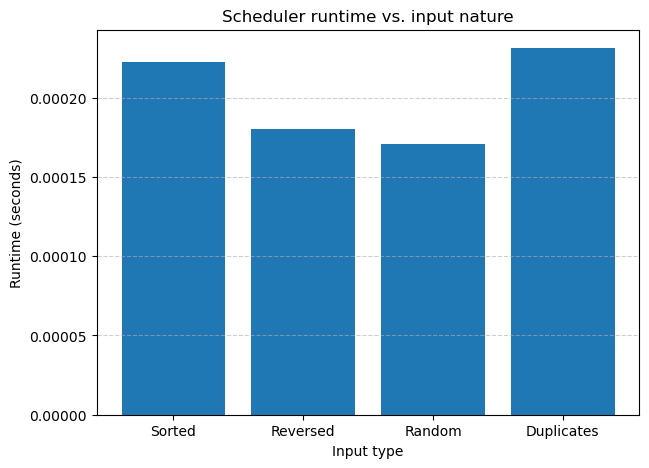

In [130]:
#1) Input nature (order) scaling - How runtime changes based on input nature?
# measure how long the scheduler takes for each input order

# minimal timing helper
import time, io, contextlib

def time_scheduler(task_list):
    """Reset tasks, run Scheduler once, return seconds (prints muted)."""
    # reset simple state
    for t in task_list:
        t.status = 'not_yet_started'
        t.priority = 0.0
    s = Scheduler(task_list)
    # silence the scheduler prints so timing isn't noisy
    buf = io.StringIO()
    with contextlib.redirect_stdout(buf):
        start = time.perf_counter()
        s.run()
        end = time.perf_counter()
    return end - start

labels  = ["Sorted", "Reversed", "Random", "Duplicates"]
inputs  = [tasks_sorted, tasks_reversed, tasks_random, tasks_duplicates]

runtimes = []
for name, lst in zip(labels, inputs):
    secs = time_scheduler(lst)
    runtimes.append(secs)
    print(f"{name}: {secs:.4f} s")

plt.figure(figsize=(7,5))
plt.bar(labels, runtimes)
plt.title("Scheduler runtime vs. input nature")
plt.xlabel("Input type")
plt.ylabel("Runtime (seconds)")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

Input size scaling (avg of 10 runs each task):
N=10: 0.0002 s
N=50: 0.0007 s
N=100: 0.0014 s
N=200: 0.0027 s
N=300: 0.0033 s
N=400: 0.0043 s
N=500: 0.0058 s
N=600: 0.0081 s
N=700: 0.0106 s
N=800: 0.0139 s
N=900: 0.0193 s
N=1000: 0.0209 s
N=1200: 0.0285 s
N=1400: 0.0379 s
N=1600: 0.0479 s
N=1800: 0.0609 s
N=2000: 0.0726 s
N=2200: 0.0879 s
N=2400: 0.1022 s
N=2600: 0.1227 s


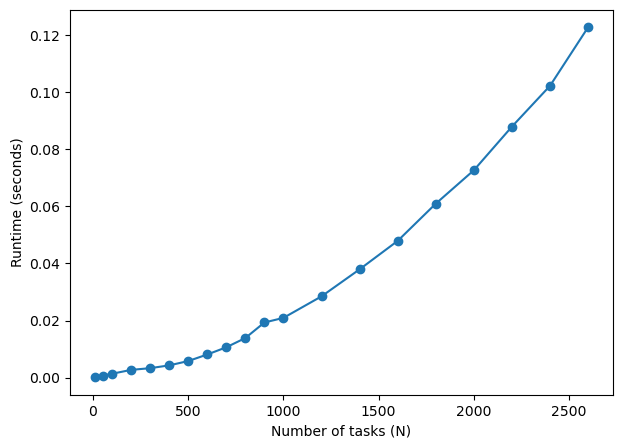

In [315]:
# 2) Input size scaling - How runtime changes as we increase task count?
# Plan:
#  - Build N tasks (no dependencies)
#  - Time Scheduler.run() for each N
#  - simulate a few times and average
#  - Plot N vs runtime

import time, io, contextlib
import matplotlib.pyplot as plt
import random

#create N tasks (no dependencies because input nature doesn't matter here)
def make_tasks(n):
    tasks = []
    for i in range(n):
        duration = random.randint(10, 60)     # small variation
        ttype = 'Fixed' if (i % 5 == 0) else 'Flexible'
        tasks.append(Task(i, f"Task {i}", duration, None, 'not_yet_started', ttype))
    return tasks

# Measure average runtime over a few repeats (reduces randomness)
def avg_runtime(task_list, repeats=5):
    total = 0.0
    for _ in range(repeats):
        total += time_scheduler_quiet(task_list)
    return total / repeats

sizes = [10, 50, 100, 200,300, 400,500,600,700, 800, 900,1000, 1200, 1400, 1600, 1800, 2000,2200, 2400,2600]
runtimes = []

print("Input size scaling (avg of 10 runs each task):")
for n in sizes:
    tasksN = make_tasks(n)
    rt = avg_runtime(tasksN, repeats=10)
    runtimes.append(rt)
    print(f"N={n}: {rt:.4f} s")

# Plot N vs runtime
plt.figure(figsize=(7,5))
plt.plot(sizes, runtimes, marker='o')
plt.xlabel("Number of tasks (N)")
plt.ylabel("Runtime (seconds)")
plt.show()


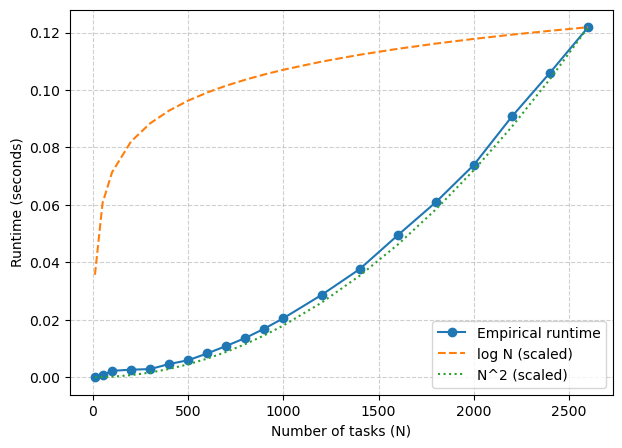

In [299]:
import numpy as np


logN = np.log2(sizes) # log base-2 
n2   = np.array(sizes, dtype=float)**2

scale_log = runtimes[-1] / logN[-1]
scale_n2  = runtimes[-1] / n2[-1]
logN_scaled = logN * scale_log
n2_scaled   = n2 * scale_n2

# Re-plot with theory curves
plt.figure(figsize=(7,5))
plt.plot(sizes, runtimes, marker='o', label="Empirical runtime")
plt.plot(sizes, logN_scaled, '--', label="log N (scaled)")
plt.plot(sizes, n2_scaled, ':',  label="N^2 (scaled)")
plt.xlabel("Number of tasks (N)")
plt.ylabel("Runtime (seconds)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()